In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [10]:
copper_model_data = pd.read_csv("/workspaces/dev/Industrial_Copper_Modelling/copper_final.csv")
copper_model_data.shape

(181667, 23)

In [4]:
copper_model_data.head(2)

item type_IPL  item type_Others  item type_PL  item type_S  \
0            0.0               0.0           0.0          0.0   
1            0.0               0.0           0.0          0.0   

   item type_SLAWR  item type_W  item type_WI  quantity tons  country status  \
0              0.0          1.0           0.0       4.191942     28.0    Won   
1              0.0          1.0           0.0       5.096583     25.0    Won   

   ...  material_ref  product_ref  selling_price  date_differ  item_date_day  \
0  ...             8   1670798778       6.749931           91              1   
1  ...        100645   1668701718       6.953684            0              1   

   item_date_month  item_date_year  delivery date_day  delivery date_month  \
0                4            2021                  1                    7   
1                4            2021                  1                    4   

   delivery date_year  
0                2021  
1                2021  

[2 rows x 23 columns]

CLASSIFICATION MODEL - "status" - WON (or) LOST

In [4]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # XGBoost typically uses the alias "xgb"

In [6]:
copper_model_data["status"].unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [11]:
copper_classify_data = copper_model_data[(copper_model_data["status"]=="Won") | (copper_model_data["status"]=="Lost")]

In [44]:
copper_classify_data.shape

(150445, 23)

In [12]:
xc = copper_classify_data.drop(columns=['status'])
yc = copper_classify_data["status"]

Decision Tree

In [11]:
x_train,x_test,y_train,y_test = train_test_split(xc,yc,stratify=yc)
print(x_train.shape)
print(x_test.shape)

(112833, 22)
(37612, 22)


In [12]:
# Training the Model
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [13]:
# y_train_pred ==> used for comparison
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

Train score 1.0
Test score 0.9430235031372967
Train Confusion matrix


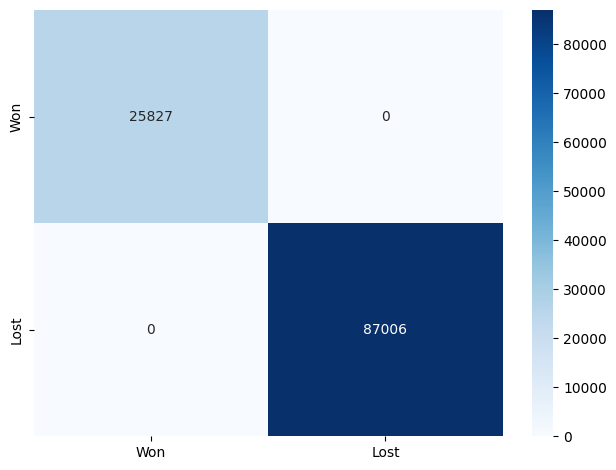

Test Confusion matrix


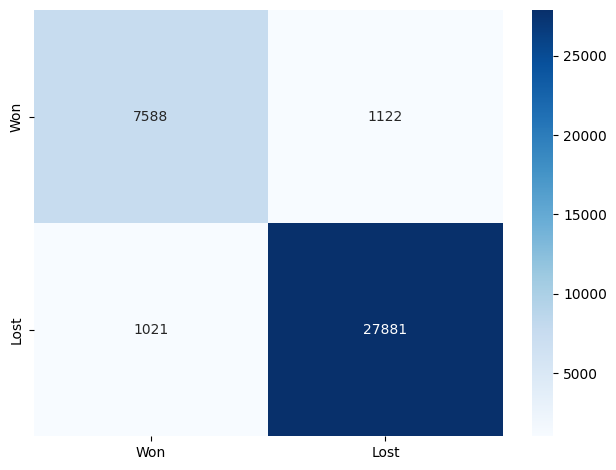

In [14]:
# Confusion Matrix & Accuracy -- Test Data compared with Train Data
def plot_confusionmatrix(y_pred,y,dom):
    classes = ['Won','Lost']
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_pred,y)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

Random Forest

In [16]:
# Splitting the Data 
X_train, X_test, Y_train, Y_test = train_test_split(xc, yc, test_size = 0.33, random_state = 42)

In [16]:
# instantiate the classifier
rfc1 = RandomForestClassifier(n_estimators=10,random_state=0)  
# fit the model
rfc1.fit(X_train, Y_train)
# Predict the Test set results
Y_pred = rfc1.predict(X_test)
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Model accuracy score with 10 decision-trees : 0.9571


In [17]:
# instantiate the classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators => number of Decision Tree taken into consideration  
# fit the model
rfc.fit(X_train, Y_train)
# Predict the Test set results
Y_pred = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Model accuracy score with 100 decision-trees : 0.9647


In [18]:
# view the feature scores
# Sort the feature columns based on its importance
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False) 
feature_scores

date_differ            0.141680
country                0.092981
item_date_day          0.088131
quantity tons          0.087676
selling_price          0.086489
application            0.070564
material_ref           0.063138
thickness              0.059487
product_ref            0.052098
item_date_month        0.048537
item type_S            0.047926
delivery date_month    0.047903
width                  0.044860
item type_W            0.030037
delivery date_day      0.017365
item_date_year         0.008675
delivery date_year     0.006744
item type_PL           0.005385
item type_Others       0.000204
item type_WI           0.000118
item type_IPL          0.000002
item type_SLAWR        0.000000
dtype: float64

XGBoost Classifier

In [19]:
ycx = yc.map({"Won":1,"Lost":0})


In [20]:
ycx.value_counts()

status
1    116009
0     34436
Name: count, dtype: int64

In [21]:
# Train and test split using sklearn
Xi_train, Xi_test, Yi_train, Yi_test= train_test_split(xc, ycx, test_size=.33, random_state=123)

In [22]:
# Instatiate a XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=123)

## Set max_depth to be 10 instead of 100
xgb_clf.set_params(n_estimators=150)

# Fit it to the training set
xgb_clf.fit(Xi_train, Yi_train)

# Predict the labels of the test set
preds = xgb_clf.predict(Xi_test)
preds

array([1, 0, 1, ..., 0, 1, 1])

In [23]:
# Calculate the accuracy
accuracy = float(np.sum(preds==Yi_test))/Yi_test.shape[0]

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.9373980300924527


Accuracy Scores of different Classifiers
- Decision Tree : 0.9416
- Random Forest Tree (n_estimators = 10) : 0.9571
- Random Forest Tree (n_estimators = 100) : 0.9647
- XGBoost Classifier : 0.9373

So Random Forest Classifier with n_estimators as 100 is chosen

In [24]:
# Save the model to a file
with open('classification.pkl', 'wb') as file:
    pickle.dump(rfc, file)

In [25]:
# Load the model from the file
with open('classification.pkl', 'rb') as file:
    rfc_model = pickle.load(file)


In [26]:
Y_pred = rfc_model.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Model accuracy score with 100 decision-trees : 0.9647


In [59]:
user_data = np.array([[0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.486837,25.0,41.0,1.79,351.0,1,640400,6.422922,19,23,9,2020,12,10,2020]])
pred_user_data = rfc_model.predict(user_data)
print("Status :",pred_user_data[0])

['Won']


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


REGRESSION MODEL -- "selling_price" Prediction

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [44]:
copper_regress_data = copper_model_data.copy()

In [51]:
copper_regress_data["status"] = copper_regress_data["status"].map({'Won':8,'Draft':1,"To be approved":4,"Lost":0,"Not lost for AM":6, "Wonderful":7,"Revised":2,"Offered":5,"Offerable":3})

In [52]:
xr = copper_regress_data.drop("selling_price",axis=1)
yr = copper_regress_data["selling_price"]

Random Forest Regressor

In [11]:
xf_train, xf_test, yf_train, yf_test = train_test_split(xr, yr, test_size=0.2, random_state=42)

In [12]:
# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(xf_train, yf_train)

RandomForestRegressor(random_state=42)

In [13]:
yf_pred = rf_regressor.predict(xf_test)
yf_pred

array([6.49046284, 6.74425236, 6.30985773, ..., 6.65467632, 6.77319676,
       6.71331561])

In [14]:
# Calculate R2 score
r2 = r2_score(yf_test, yf_pred)
print(f"R2 Score: {r2:.2f}")


R2 Score: 0.96


XGBoost Regressor

In [15]:
xg_train, xg_test, yg_train, yg_test = train_test_split(xr, yr, test_size=0.2, random_state=42)

In [16]:
# Initialize the XGBRegressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_regressor.fit(xg_train, yg_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
yg_pred = xgb_regressor.predict(xg_test)
yg_pred

array([6.5032425, 6.79369  , 6.2854137, ..., 6.6497126, 6.7759485,
       6.679069 ], dtype=float32)

In [18]:
r2 = r2_score(yg_test, yg_pred)
print(f"R2 Score: {r2:.2f}")

R2 Score: 0.96


Accuracy Scores of different Regressors :
- Random Forest Regressor : 0.96
- XGBoost Regressor : 0.96

Both have similar accuracy - anyone can be chosen for prediction. Here we use XGBoost Regressor for prediction

In [19]:
# Save the model to a file
with open('regression.pkl', 'wb') as file:
    pickle.dump(xgb_regressor, file)

In [20]:
# Load the model from the file
with open('regression.pkl', 'rb') as file:
    xgbr_model = pickle.load(file)

In [21]:
yg_pred = xgbr_model.predict(xg_test)
r2 = r2_score(yg_test, yg_pred)
print(f"R2 Score: {r2:.2f}")

R2 Score: 0.96


In [26]:
user_data = np.array([[0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.09,28.0,8.0,59.0,2.0,1410.0,100645.0,64064.0,77,16,3,2021,1,6,2021]])

In [28]:
pred_user_data = xgbr_model.predict(user_data)
print(pred_user_data)

[6.955245]


In [56]:
pred_user_data = 6.5
original_selling_price = np.exp(pred_user_data)
print("Predicted Selling Price :",original_selling_price)
print(type(original_selling_price))

Predicted Selling Price : 665.1416330443618
<class 'numpy.float64'>


get_user_input

In [33]:
copper_model_data.columns

Index(['item type_IPL', 'item type_Others', 'item type_PL', 'item type_S',
       'item type_SLAWR', 'item type_W', 'item type_WI', 'quantity tons',
       'country', 'status', 'application', 'thickness', 'width',
       'material_ref', 'product_ref', 'selling_price', 'date_differ',
       'item_date_day', 'item_date_month', 'item_date_year',
       'delivery date_day', 'delivery date_month', 'delivery date_year'],
      dtype='object')

In [35]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 20.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 16.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 6.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 1.6 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [37]:
!pip install streamlit_option_menu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.4/823.4 kB 3.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [38]:
import streamlit as st
from streamlit_option_menu import option_menu

In [39]:
copper_model_data.columns

Index(['item type_IPL', 'item type_Others', 'item type_PL', 'item type_S',
       'item type_SLAWR', 'item type_W', 'item type_WI', 'quantity tons',
       'country', 'status', 'application', 'thickness', 'width',
       'material_ref', 'product_ref', 'selling_price', 'date_differ',
       'item_date_day', 'item_date_month', 'item_date_year',
       'delivery date_day', 'delivery date_month', 'delivery date_year'],
      dtype='object')

In [31]:
def item_type_input(item_type):
    item_type_IPL = 0.0
    item_type_Others = 0.0
    item_type_PL = 0.0
    item_type_S = 0.0
    item_type_SLAWR = 0.0
    item_type_W = 0.0
    item_type_WI = 0.0
    if item_type == "W":
        item_type_W = 1.0
    elif item_type == "WI":
        item_type_WI = 1.0
    elif item_type == "S":
        item_type_S = 1.0
    elif item_type == "Others":
        item_type_Others = 1.0
    elif item_type == "PL":
        item_type_PL = 1.0
    elif item_type == "IPL":
        item_type_IPL = 1.0
    elif item_type == "SLAWR":
        item_type_SLAWR = 1.0
    return item_type_W, item_type_WI, item_type_S, item_type_Others, item_type_PL, item_type_IPL, item_type_SLAWR

In [4]:
def item_date_input(item_date):
    item_date_day = item_date.dt.day
    item_date_month = item_date.dt.month
    item_date_year = item_date.dt.year

In [5]:
def delivery_date_input(delivery_date):
    delivery_date_day = delivery_date.dt.day
    delivery_date_month = delivery_date.dt.month
    delivery_date_year = delivery_date.dt.year

In [ ]:
st.set_page_config(layout="wide")
st.title(":red[INDUSTRIAL COPPER MODELING]")

tab1, tab2 = st.tabs(["Classification","Regression"])
with tab1:
    col1, col2 = st.columns(2)
    pred_user_output1 = [""]
    with col1:
        item_type_list = ['IPL', 'Others', 'PL', 'S', 'SLAWR', 'W', 'WI']
        item_type = st.selectbox("Item Type",item_type_list)
        i = item_type_input(item_type)                                                      # Value of encoded 7 columns calculated
        quantity_tons = st.text_input("Quantity Tons (Range : 0 to 150)",value=0)
        # Try to convert if it's not empty
        if quantity_tons:
            try:
                quantity_tons_log = np.log(int(quantity_tons)+12)                           # Log transformed value is considered as input
            except ValueError:
                st.error("Invalid input: Please enter a valid number")
        country = st.selectbox("Country",copper_classify_data["country"].unique().tolist())
        application = st.selectbox("Application",copper_classify_data["application"].unique().tolist())
        thickness = st.text_input("Thickness (Range : 0 to 7)",value=0)                                              
        # Try to convert if it's not empty
        if thickness:
            try:
                thickness_log = np.log(int(thickness)+1)                                    # Log transformed value is considered as input
            except ValueError:
                st.error("Invalid input: Please enter a valid number")
        width = st.text_input("Width (Range : 20 to 2000)",value=0)
        width = float(width)
    with col2:
        material_ref = st.selectbox("Material Reference",copper_classify_data["material_ref"].unique().tolist())
        product_ref = st.selectbox("Product Reference",copper_classify_data["product_ref"].unique().tolist())
        selling_price = st.text_input("Selling Price (Range : 200 to 1400)",value=0)
        # Try to convert if it's not empty
        if selling_price:
            try:
                selling_price_log = np.log(int(selling_price))                              # Log transformed value is considered as input
            except ValueError:
                st.error("Invalid input: Please enter a valid number")
        today = datetime.today().date()
        item_date = st.date_input("Item Date",value=today)
        id = item_date_input(item_date)                                                     # Values of splitted 3 columns calculated
        delivery_date = st.date_input("Delivery Date",value=today)
        dd = delivery_date_input(delivery_date)                                             # Values of splitted 3 columns calculated
        # Calculate date_differ
        item_date = pd.to_datetime(item_date)
        delivery_date = pd.to_datetime(delivery_date)
        date_differ = (delivery_date - item_date).days
    if st.button("Classify Status",use_container_width = True):
        user_input1 = np.array([[i[0], i[1], i[2], i[3], i[4], i[5], i[6],
                                  quantity_tons_log, country, application, thickness_log, width, material_ref, product_ref, selling_price_log, 
                                  date_differ, id[0], id[1], id[2], dd[0], dd[1], dd[2]]])
        pred_user_output1 = rfc_model.predict(user_input1)
    st.header(pred_user_output1[0])

with tab2:
    col1, col2 = st.columns(2)
    with col1:
        item_type_list = ['IPL', 'Others', 'PL', 'S', 'SLAWR', 'W', 'WI']
        item_type = st.selectbox("Item Type ",item_type_list)
        i = item_type_input(item_type)                                                      # Value of encoded 7 columns calculated
        quantity_tons = st.text_input("Quantity Tons (Range : 0 to 150) ",value=0)
        # Try to convert if it's not empty
        if quantity_tons:
            try:
                quantity_tons_log = np.log(int(quantity_tons)+12)                           # Log transformed value is considered as input
            except ValueError:
                st.error("Invalid input: Please enter a valid number")
        country = st.selectbox("Country ",copper_regress_data["country"].unique().tolist())
        status = st.selectbox("Status ", copper_regress_data["status"].unique().tolist())
        status_map = {'Won':8,'Draft':1,"To be approved":4,"Lost":0,"Not lost for AM":6, "Wonderful":7,"Revised":2,"Offered":5,"Offerable":3}
        mapped_status = status_map.get(status)
        application = st.selectbox("Application ",copper_regress_data["application"].unique().tolist())
        thickness = st.text_input("Thickness (Range : 0 to 7) ",value=0)                                              
        # Try to convert if it's not empty
        if thickness:
            try:
                thickness_log = np.log(int(thickness)+1)                                    # Log transformed value is considered as input
            except ValueError:
                st.error("Invalid input: Please enter a valid number")

    with col2:
        width = st.text_input("Width (Range : 20 to 2000) ",value=0)
        width = float(width)
        material_ref = st.selectbox("Material Reference ",copper_classify_data["material_ref"].unique().tolist())
        product_ref = st.selectbox("Product Reference ",copper_classify_data["product_ref"].unique().tolist())
        today = datetime.today().date()
        item_date = st.date_input("Item Date ",value=today)
        id = item_date_input(item_date)                                                     # Values of splitted 3 columns calculated
        delivery_date = st.date_input("Delivery Date ",value=today)
        dd = delivery_date_input(delivery_date)                                             # Values of splitted 3 columns calculated
        # Calculate date_differ
        item_date = pd.to_datetime(item_date)
        delivery_date = pd.to_datetime(delivery_date)
        date_differ = (delivery_date - item_date).days
    if st.button("Predict Selling Price",use_container_width = True):
        user_input2 = np.array([[i[0], i[1], i[2], i[3], i[4], i[5], i[6],
                                  quantity_tons_log, country, mapped_status, application, thickness_log, width, material_ref, product_ref, 
                                  date_differ, id[0], id[1], id[2], dd[0], dd[1], dd[2]]])
        pred_user_output2 = xgbr_model.predict(user_input2)
        original_selling_price = np.exp(pred_user_output2)
        st.write("Predicted Selling Price :",original_selling_price[0])